# (11) HRF

**Motivation**: Apply gamma-variate HRF to CA data, save results with ```desc-hrf```. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


# Functions from Gabe:

# default time_length of 30sec as in Ma et al. 2016
def gamma_hrf(tr, oversampling=50, time_length=30., onset=0.,
                          delay=6, scale=1):
    """Generate a gamma hrf kernel
    Adapted from https://github.com/nilearn/nilearn/blob/9ddfa7259de3053a5ed6655cd662e115926cf6a5/nilearn/glm/first_level/hemodynamic_models.py#L18
    
    Parameters
    ----------
    tr : float
        Scan repeat time, in seconds.
    oversampling : int, optional
        Temporal oversampling factor.
        Default=50.
    time_length : float, optional
        hrf kernel length, in seconds.
        Default=32.
    onset : float, optional
        Onset time of the hrf. Default=0.
    delay : float, optional
        Delay parameter of the hrf (in s.).
        Default=6s.
    scale : float, optional
        Scale parameter of the hrf
        Default=1.
    Returns
    -------
    hrf : array of shape(length / tr * oversampling, dtype=float)
         hrf sampling on the oversampled time grid
    """
    dt = tr / oversampling
    time_stamps = np.linspace(
        0, time_length,
        np.rint(float(time_length) / dt).astype(int))
    time_stamps -= onset
    
    # time_stamps are the timepoints defining the time window of the kernel
    # a correspondings to the delay until the peak
    # loc defines when the function begins; equivalent to the onset, so it is set to 0
    # scale defines the width of the gamma function
    # free parameters are a and scale
    hrf = sp_stats.gamma.pdf(x=time_stamps, a=delay, loc=0, scale=scale)
    hrf /= hrf.sum()
    return hrf


def hrf_convolution(calcium_trace, gamma_delay, gamma_width, amplitude, onset):
    # inspired from https://github.com/nilearn/nilearn/blob/9ddfa7259de3053a5ed6655cd662e115926cf6a5/nilearn/glm/first_level/hemodynamic_models.py#L517

    # ignoring the oversampling since the 10Hz sampling of the calcium should be sufficient
    oversampling=1
    tr = 0.1 # the tr of 0.1Hz from calcium
    
    hkernel = gamma_hrf(tr, oversampling=oversampling, time_length=30., onset=onset,
                          delay=gamma_delay, scale=gamma_width)
    
    # dot product is applied with sliding window
    convolved = np.convolve(calcium_trace, hkernel)
    # extra timepoints are generated since the kernel is applied at the tail with missing timepoints; those extra timepoints are removed
    convolved = convolved[:calcium_trace.size]
    
    # final parameter managing the amplitude scaling
    convolved *= amplitude
        
    return convolved

## Setup

In [3]:
mice = Mice(512)
mice.setup_func_data(desc_ca2='preproc')

## Test HRF

In [4]:
x = np.zeros(300)
x[100] = 1

y = hrf_convolution(
    calcium_trace=x,
    gamma_delay=2.6,
    gamma_width=1.2,
    amplitude=10,
    onset=0.4,
)

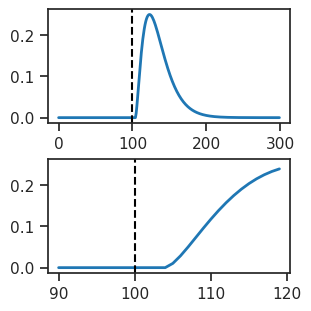

In [5]:
fig, axes = create_figure(2, 1, (3, 3), sharey='all', layout='constrained')
axes[0].plot(y, lw=2)
axes[0].axvline(100, color='k', ls='--')

intvl = range(90, 120)
axes[1].plot(intvl, y[intvl], lw=2)
axes[1].axvline(100, color='k', ls='--')

plt.show()

## Test on actual ca trace

In [19]:
for k, f in mice.ca.items():
    x = f[:]

In [20]:
initial_offset = 500

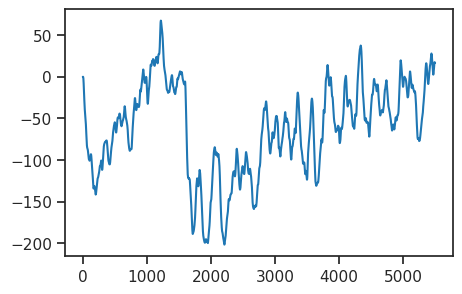

In [21]:
i = 100
y = hrf_convolution(
    calcium_trace=x[i][initial_offset:],
    gamma_delay=2.6,
    gamma_width=1.2,
    amplitude=1,
    onset=0.4,
)
plt.plot(y);

In [22]:
y.shape

(5500,)

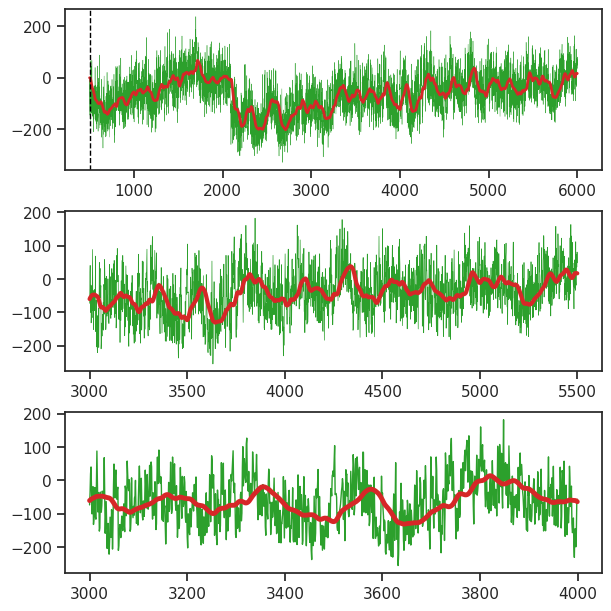

In [23]:
fig, axes = create_figure(3, 1, (6, 6), sharex='none', sharey='none', layout='constrained')

intvl = range(initial_offset, 6000)
axes[0].plot(intvl, x[i][intvl], color='C2', lw=0.3)
axes[0].plot(intvl, y, color='C3', lw=2.0)
axes[0].axvline(500, color='k', ls='--', lw=1.0)

intvl = np.array(range(3000, 5500))
axes[1].plot(intvl, x[i][intvl + initial_offset], color='C2', lw=0.5)
axes[1].plot(intvl, y[intvl], color='C3', lw=3)

intvl = np.array(range(3000, 4000))
axes[2].plot(intvl, x[i][intvl + initial_offset], color='C2', lw=1.0)
axes[2].plot(intvl, y[intvl], color='C3', lw=3.5)
plt.show()

In [24]:
initial_offset = 0

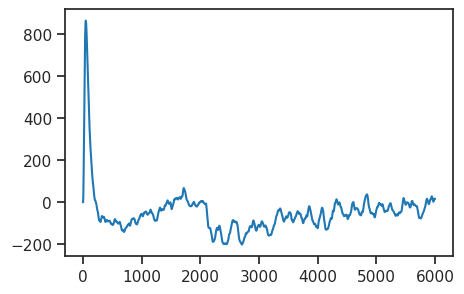

In [25]:
i = 100
y = hrf_convolution(
    calcium_trace=x[i][initial_offset:],
    gamma_delay=2.6,
    gamma_width=1.2,
    amplitude=1,
    onset=0.4,
)
plt.plot(y);

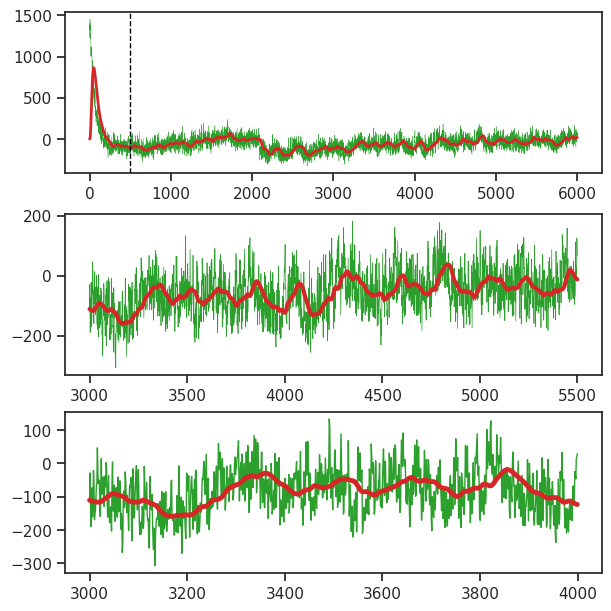

In [26]:
fig, axes = create_figure(3, 1, (6, 6), sharex='none', sharey='none', layout='constrained')

intvl = range(initial_offset, 6000)
axes[0].plot(intvl, x[i][intvl], color='C2', lw=0.3)
axes[0].plot(intvl, y, color='C3', lw=2.0)
axes[0].axvline(500, color='k', ls='--', lw=1.0)

intvl = np.array(range(3000, 5500))
axes[1].plot(intvl, x[i][intvl + initial_offset], color='C2', lw=0.5)
axes[1].plot(intvl, y[intvl], color='C3', lw=3)

intvl = np.array(range(3000, 4000))
axes[2].plot(intvl, x[i][intvl + initial_offset], color='C2', lw=1.0)
axes[2].plot(intvl, y[intvl], color='C3', lw=3.5)
plt.show()

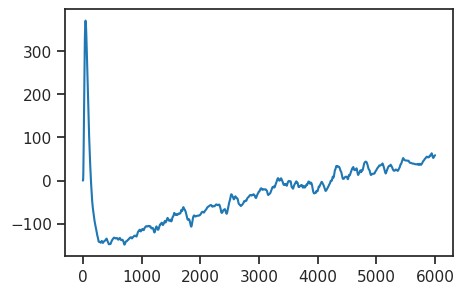

In [27]:
i = 120
y = hrf_convolution(
    calcium_trace=x[i][initial_offset:],
    gamma_delay=2.6,
    gamma_width=1.2,
    amplitude=1,
    onset=0.4,
)
plt.plot(y);

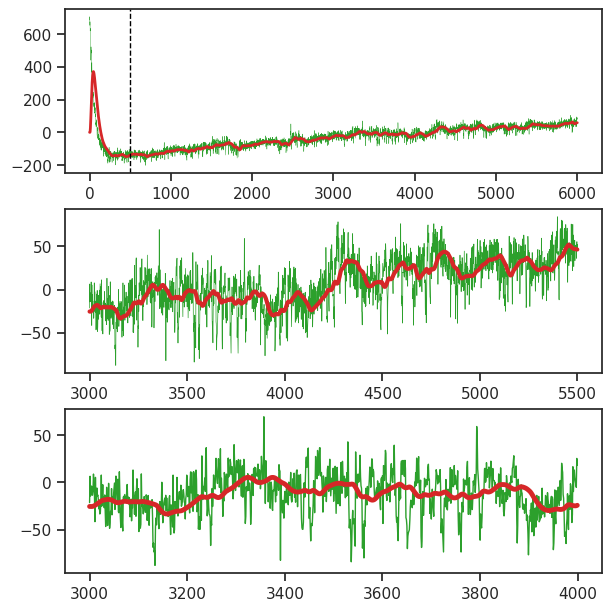

In [28]:
fig, axes = create_figure(3, 1, (6, 6), sharex='none', sharey='none', layout='constrained')

intvl = range(initial_offset, 6000)
axes[0].plot(intvl, x[i][intvl], color='C2', lw=0.3)
axes[0].plot(intvl, y, color='C3', lw=2.0)
axes[0].axvline(500, color='k', ls='--', lw=1.0)

intvl = np.array(range(3000, 5500))
axes[1].plot(intvl, x[i][intvl + initial_offset], color='C2', lw=0.5)
axes[1].plot(intvl, y[intvl], color='C3', lw=3)

intvl = np.array(range(3000, 4000))
axes[2].plot(intvl, x[i][intvl + initial_offset], color='C2', lw=1.0)
axes[2].plot(intvl, y[intvl], color='C3', lw=3.5)
plt.show()